In [1]:
!git clone https://github.com/parhamzm/Beijing-Pollution-DataSet

fatal: destination path 'Beijing-Pollution-DataSet' already exists and is not an empty directory.


In [2]:
!ls Beijing-Pollution-DataSet

pollution.csv  polution_dataSet.npy  README.md


In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import random_split

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from numpy import array
from numpy import hstack

# **Data Pre Processing**

In [4]:
DATA_DIR = "Beijing-Pollution-DataSet/"
from pandas import read_csv
from datetime import datetime
from random import randint

def select_week(sequences, n_samples=250):
    X, y = list(), list()
    rand_hour = 360 #randint(0, 24)
    for i in range(0, n_samples):
        start_ix = rand_hour #+ 168 * i # 168 : Week hours!
        idxs = []
        for j in range(0, 7):
            if j <=5:
                idx = start_ix + (j * 24) # Add different days in week
                # print("Id x Week:=> ", idx)
                idxs.append(idx)
            if j == 6: # Target
                idy = start_ix + (j * 24)
        seq_x = sequences[idxs, :]
        seq_y = sequences[idy, 0]
        y.append(seq_y)
        X.append(seq_x)
        # print("Id y Week:=> ", idy)
        rand_hour += 1
    return X, y


def select_month(sequences, n_samples=250):
    X, y = list(), list()
    rand_hour = 0 #randint(0, 24)
    rand_day = 0 #randint(0, 7)
    for i in range(0, n_samples):
        start_ix = rand_hour #+ rand_day*24 + 672 * i # 168 : Week hours!
        idxs = []
        for j in range(0, 4):
            if j <=2:
                idx = start_ix + (j * 168) # Add different weeks
                idxs.append(idx)
                # print("Id x Month:=> ", idx)
                # print("Hello")
            if j == 3: # Target
                idy = start_ix + (j * 168)
        seq_x = sequences[idxs, :]
        seq_y = sequences[idy, 0]
        # print("Id y Month:=> ", idy)
        y.append(seq_y)
        X.append(seq_x)

        rand_hour += 1

    return X, y


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps=11, n_samples=12000, start_from=493):
	X, y = list(), list()
	for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
		end_ix = i + n_steps
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
		seq_x = sequences[i:end_ix, :]
		seq_y = sequences[end_ix, 0]
		y.append(seq_y)
		X.append(seq_x)
  
	return array(X), array(y)


# load dataset
DATA_DIR = "Beijing-Pollution-DataSet/"

data = np.load(DATA_DIR + 'polution_dataSet.npy')
scaled_data = data

# specify the number of lag hours
n_hours = 11
n_features = 8


x_week, y_week = select_week(data, n_samples=33000)
print("X-Week shape => ", np.array(x_week).shape)
print("y-Week shape => ", np.array(y_week).shape)
x_week = np.array(x_week)
y_week = np.array(y_week)

x_month, y_month = select_month(data, n_samples=33000)
print("X-Month shape => ", np.array(x_month).shape)
print("y-Month shape => ", np.array(y_month).shape)
x_month = np.array(x_month)
y_month = np.array(y_month)

n_timesteps = 11
dataset = data
print(data.shape)
day_X, day_y = split_sequences(sequences=dataset, n_steps=n_timesteps, n_samples=33000)
print("X-Day shape => ", np.array(day_X).shape)
print("y-Day shape => ", np.array(day_y).shape)

x_day_test, y_day_test = day_X[27000:30000], day_y[27000:30000]
x_week_test, y_week_test = x_week[27000:30000], y_week[27000:30000]
x_month_test, y_month_test = x_month[27000:30000], y_month[27000:30000]

x_day_train, y_day_train = day_X[:27000], day_y[:27000]
x_week_train, y_week_train = x_week[:27000], y_week[:27000]
x_month_train, y_month_train = x_month[:27000], y_month[:27000]

X-Week shape =>  (33000, 6, 8)
y-Week shape =>  (33000,)
X-Month shape =>  (33000, 3, 8)
y-Month shape =>  (33000,)
(43799, 8)
X-Day shape =>  (33000, 11, 8)
y-Day shape =>  (33000,)


In [5]:
y_batch_test1 = torch.tensor(day_y, dtype=torch.float32)
y_batch_test2 = torch.tensor(y_week, dtype=torch.float32)
y_batch_test3 = torch.tensor(y_month, dtype=torch.float32)
criterion = nn.MSELoss()

loss_test = criterion(y_batch_test1, y_batch_test2)

# train_X = torch.tensor(train_X, dtype=torch.float32)    
# train_y = torch.tensor(train_y, dtype=torch.float32)
loss_test.item()

0.0

In [0]:
class LSTM(torch.nn.Module):
    def __init__(self, n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1, dropout=0):
        super(LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length

        self.n_hidden = n_hidden_layers # number of hidden states
        self.n_layers = n_layers # number of LSTM layers (stacked)
        self.n_output = n_output

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers,
                                 dropout=dropout,
                                 batch_first = True)
        
        self.lstm2 = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers,
                                 dropout=dropout,
                                 batch_first = True)
        
        self.lstm3 = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers,
                                 dropout=dropout,
                                 batch_first = True)

        self.l_linear = torch.nn.Linear(self.n_hidden * self.seq_len, self.n_output)
        self.linear2 = torch.nn.Linear(self.n_hidden * 6, self.n_output)
        self.linear3 = torch.nn.Linear(self.n_hidden * 3, self.n_output)
        self.avgpool = nn.AvgPool1d(kernel_size=3, stride=3, padding=0)


    def forward(self, x1, x2, x3):
        hidden_state = torch.zeros(self.n_layers, x1.size(0), self.n_hidden).requires_grad_()
        cell_state = torch.zeros(self.n_layers, x1.size(0), self.n_hidden).requires_grad_()
        self.hidden = (hidden_state.detach(), cell_state.detach())
        batch_size, seq_len, _ = x1.size()
        lstm_out, self.hidden = self.l_lstm(x1, self.hidden)
        x = lstm_out.contiguous().view(batch_size, -1)
        out1 = self.l_linear(x)

        hidden_state = torch.zeros(self.n_layers, x2.size(0), self.n_hidden).requires_grad_()
        cell_state = torch.zeros(self.n_layers, x2.size(0), self.n_hidden).requires_grad_()
        self.hidden = (hidden_state.detach(), cell_state.detach())
        batch_size, seq_len, _ = x2.size()
        lstm_out, self.hidden = self.lstm2(x2, self.hidden)
        x = lstm_out.contiguous().view(batch_size, -1)
        out2 = self.linear2(x)

        hidden_state = torch.zeros(self.n_layers, x3.size(0), self.n_hidden).requires_grad_()
        cell_state = torch.zeros(self.n_layers, x3.size(0), self.n_hidden).requires_grad_()
        self.hidden = (hidden_state.detach(), cell_state.detach())
        batch_size, seq_len, _ = x3.size()
        lstm_out, self.hidden = self.lstm3(x3, self.hidden)
        x = lstm_out.contiguous().view(batch_size, -1)
        out3 = self.linear3(x)

        x3 = torch.cat((out1, out2, out3), dim=1).view(1, 1, batch_size*3) #.unsqueeze_(-1) #.view(-1)
        # a.unsqueeze_(-1)
        # print("X3 shape :=> ", x3.shape)

        out = self.avgpool(x3)
        # print("out size = => ", out.shape)

        return out

In [0]:
torch.manual_seed(13)
model = LSTM(n_features=8, n_output=1, seq_length=11, n_hidden_layers=233, n_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [8]:
model = model #.to(device)
criterion = criterion #.to(device)
for p in model.parameters():
    print(p.numel())

7456
217156
932
932
7456
217156
932
932
7456
217156
932
932
2563
1
1398
1
699
1


In [9]:
import time
start_time = time.time()

# train_X, train_y
epochs = 100
model.train()
batch_size = 200
running_loss_history = []
val_running_loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    val_running_loss = 0.0
    model.train()
    for b in range(0, len(x_day_train), batch_size):
        inpt1 = x_day_train[b:b+batch_size, :, :]
        target1 = y_day_train[b:b+batch_size]

        inpt2 = x_week_train[b:b+batch_size, :, :]
        target2 = y_week_train[b:b+batch_size]

        inpt3 = x_month_train[b:b+batch_size, :, :]
        target3 = y_month_train[b:b+batch_size]

        # print("Input Shape :=> ", inpt.shape)

        x_batch1 = torch.tensor(inpt1, dtype=torch.float32)    
        y_batch1 = torch.tensor(target1, dtype=torch.float32)

        x_batch2 = torch.tensor(inpt2, dtype=torch.float32)    
        y_batch2 = torch.tensor(target2, dtype=torch.float32)

        x_batch3 = torch.tensor(inpt3, dtype=torch.float32)    
        y_batch3 = torch.tensor(target3, dtype=torch.float32)

        output = model(x_batch1, x_batch2, x_batch3) 
        loss = criterion(output.view(-1), y_batch1)

        running_loss += loss.item()

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    else:
        
        with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
            model.eval()
            for b in range(0, len(x_day_test), batch_size):
                inpt1 = x_day_test[b:b+batch_size, :, :]
                target1 = y_day_test[b:b+batch_size]

                inpt2 = x_week_test[b:b+batch_size, :, :]
                target2 = y_week_test[b:b+batch_size]

                inpt3 = x_month_test[b:b+batch_size, :, :]
                target3 = y_month_test[b:b+batch_size]

                x_batch1 = torch.tensor(inpt1, dtype=torch.float32)    
                y_batch1 = torch.tensor(target1, dtype=torch.float32)

                x_batch2 = torch.tensor(inpt2, dtype=torch.float32)    
                y_batch2 = torch.tensor(target2, dtype=torch.float32)

                x_batch3 = torch.tensor(inpt3, dtype=torch.float32)    
                y_batch3 = torch.tensor(target3, dtype=torch.float32)

                output_test = model(x_batch1, x_batch2, x_batch3) 
                loss_test = criterion(output_test.view(-1), y_batch1)

                val_running_loss += loss_test.item()

    val_epoch_loss = val_running_loss / len(x_day_test)
    val_running_loss_history.append(val_epoch_loss)
    epoch_loss = running_loss / len(x_day_train)
    running_loss_history.append(epoch_loss)
    print('step : ' , epoch , ' Train loss : ' , epoch_loss, ', Valid Loss : => ', val_epoch_loss)
    print("***->>>-----------------------------------------------<<<-***")

total_time = time.time() - start_time
print("===========================================================")
print("*********************************************************")
print("The total Training Time is Equal with ==> : {0} Sec.".format(total_time))
print("*********************************************************")
print("===========================================================")

step :  0  Train loss :  3.51905343489273e-05 , Valid Loss : =>  0.00021972281392663718
***->>>-----------------------------------------------<<<-***
step :  1  Train loss :  4.0000458577803026e-05 , Valid Loss : =>  3.4736850531771776e-05
***->>>-----------------------------------------------<<<-***
step :  2  Train loss :  3.3358957014839956e-05 , Valid Loss : =>  1.8175863680274537e-05
***->>>-----------------------------------------------<<<-***
step :  3  Train loss :  1.8889483810333466e-05 , Valid Loss : =>  2.0077199093066155e-05
***->>>-----------------------------------------------<<<-***
step :  4  Train loss :  1.8793565444260216e-05 , Valid Loss : =>  1.432152701697002e-05
***->>>-----------------------------------------------<<<-***
step :  5  Train loss :  1.5019071275471813e-05 , Valid Loss : =>  1.24088148586452e-05
***->>>-----------------------------------------------<<<-***
step :  6  Train loss :  1.2354581347338994e-05 , Valid Loss : =>  1.0060687413594375e-05
***

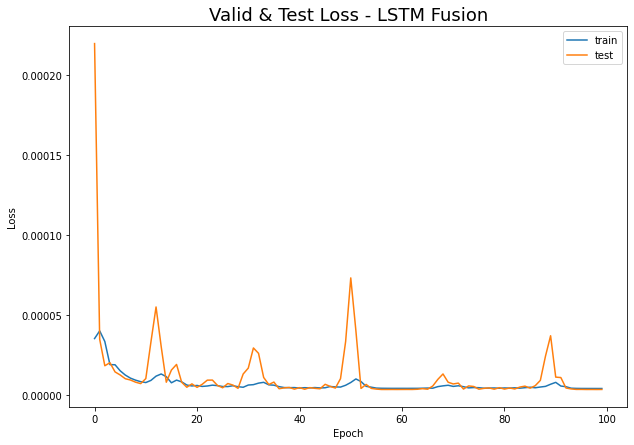

torch.Size([1, 1, 7])

In [20]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.title("Valid & Test Loss - LSTM Fusion", fontsize=18)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(running_loss_history, label='train')
plt.plot(val_running_loss_history, label='test')
# pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
x = torch.tensor([[[1.,2,3,4,5,6,7]]])
x.shape

In [0]:
x_day_test, y_day_test = day_X[29900:30000], day_y[29900:30000]
x_week_test, y_week_test = x_week[29900:30000], y_week[29900:30000]
x_month_test, y_month_test = x_month[29900:30000], y_month[29900:30000]

future = 100
window_size = 11

model.eval()
x_day_test = torch.tensor(x_day_test, dtype=torch.float32)
x_week_test = torch.tensor(x_week_test, dtype=torch.float32)
x_month_test = torch.tensor(x_month_test, dtype=torch.float32)

res = model(x_day_test, x_week_test, x_month_test)
# print(preds[11:])

torch.Size([1, 1, 100])


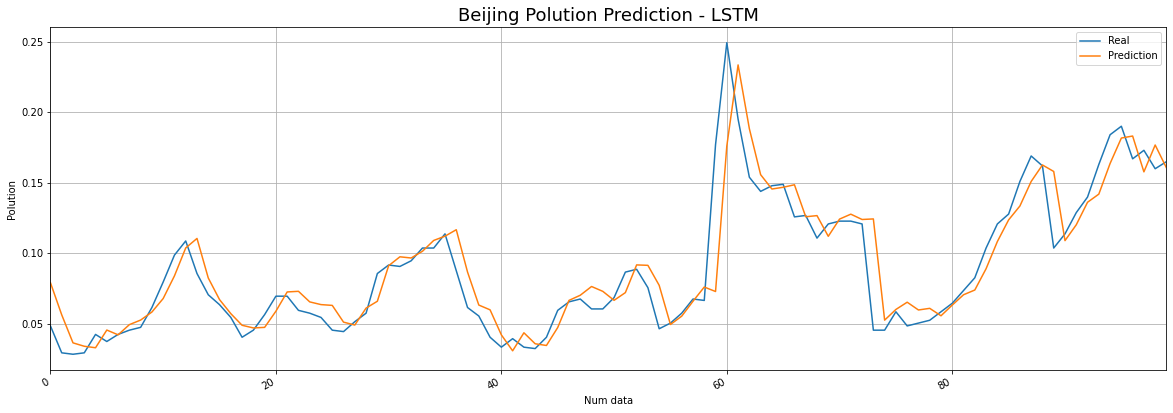

In [17]:
fig = plt.figure(figsize=(20, 7))
plt.title("Beijing Polution Prediction - LSTM", fontsize=18)
plt.ylabel('Polution')
plt.xlabel('Num data')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

# plt.plot(data[15000:15100, 0])
plt.plot(y_day_test, label="Real")
# plt.plot(preds[12:])
print(res.shape)
plt.plot(res.flatten().detach().numpy(), label="Prediction")
plt.legend()
plt.show()

In [19]:
x_day_test, y_day_test = day_X[30000:33000], day_y[30000:33000]
x_week_test, y_week_test = x_week[30000:33000], y_week[30000:33000]
x_month_test, y_month_test = x_month[30000:33000], y_month[30000:33000]

model.eval()
x_day_test = torch.tensor(x_day_test, dtype=torch.float32)
x_week_test = torch.tensor(x_week_test, dtype=torch.float32)
x_month_test = torch.tensor(x_month_test, dtype=torch.float32)


test_running_loss = 0
with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
    model.eval()
    for b in range(0, len(x_day_test), batch_size):
        inpt1 = x_day_test[b:b+batch_size, :, :]
        target1 = y_day_test[b:b+batch_size]

        inpt2 = x_week_test[b:b+batch_size, :, :]
        target2 = y_week_test[b:b+batch_size]

        inpt3 = x_month_test[b:b+batch_size, :, :]
        target3 = y_month_test[b:b+batch_size]

        x_batch1 = torch.tensor(inpt1, dtype=torch.float32)    
        y_batch1 = torch.tensor(target1, dtype=torch.float32)

        x_batch2 = torch.tensor(inpt2, dtype=torch.float32)    
        y_batch2 = torch.tensor(target2, dtype=torch.float32)

        x_batch3 = torch.tensor(inpt3, dtype=torch.float32)    
        y_batch3 = torch.tensor(target3, dtype=torch.float32)

        output_test = model(x_batch1, x_batch2, x_batch3) 
        loss_test = criterion(output_test.view(-1), y_batch1)

        test_running_loss += loss_test.item()

    test_epoch_loss = test_running_loss / len(x_day_test)

print("##########################################################")
print(">>>>---------------------------------------------------<<<<")
print(">>>>----------***************************--------------<<<<")
print("**** Test Loss :==>>> ", test_epoch_loss)
print(">>>>----------***************************--------------<<<<")
print(">>>>---------------------------------------------------<<<<")
print("##########################################################")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


##########################################################
>>>>---------------------------------------------------<<<<
>>>>----------***************************--------------<<<<
**** Test Loss :==>>>  1.8115157727152109e-06
>>>>----------***************************--------------<<<<
>>>>---------------------------------------------------<<<<
##########################################################


# **Predict Only 12 & 24 Times!**

In [0]:
# split a multivariate sequence into samples
def split_sequences12(sequences, n_steps, n_samples=12000, start_from=0):
    X, y = list(), list()
    j = 0
    for i in range(start_from, (start_from + n_samples)):
        # find the end of this pattern
        end_ix = j*12 + n_steps + start_from
        # check if we are beyond the dataset
        # gather input and output parts of the pattern
        j = j + 1
        seq_x = sequences[end_ix-11:end_ix, :]
        seq_y = sequences[end_ix, 0]
        y.append(seq_y)
        X.append(seq_x)
    print("End :=> ", end_ix)
    return array(X), array(y)

In [0]:
x, y = split_sequences12(sequences=dataset, n_steps=11, n_samples=100, start_from=20500)
x = torch.tensor(x, dtype=torch.float32)
x.shape

In [0]:
model.eval()
res = model(x)

In [0]:
fig = plt.figure(figsize=(20, 7))
plt.title("Beijing Polution Prediction - 12Hour", fontsize=18)
plt.ylabel('Polution')
plt.xlabel('Num data')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

# plt.plot(data[15000:15100, 0])
plt.plot(y, label="Real")
# plt.plot(preds[12:])
print(res.shape)
plt.plot(res.detach().numpy(), label="Prediction")
plt.legend()
plt.show()

In [0]:
df_y = DataFrame(y)

df_y.columns = ['Real Values']
df_y['Predicted Values'] = res.detach().numpy()
# dataset.index.name = 'date'

In [0]:
pd.set_option("max_rows", None)
df_y.to_csv('Predict_every12Hour_LSTM_ADAM_MSE.csv')
df_y